<a href="https://colab.research.google.com/github/sapiotee54/Phase5_Capstone-Project/blob/main/corrosion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the dataset directory on Google Drive
dataset_dir_train = '/content/drive/MyDrive/train'
dataset_dir_test = '/content/drive/MyDrive/test'
dataset_dir_val = '/content/drive/MyDrive/validation'

In [ ]:
# Define constants
num_classes = 2
batch_size = 32
img_height = 224
img_width = 224

# Using ImageDataGenerator for data loading and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Increased rotation
    width_shift_range=0.3,   # Increased shift
    height_shift_range=0.3,  # Increased shift
    shear_range=0.3,         # Increased shear
    zoom_range=0.3,          # Increased zoom
    horizontal_flip=True,
    vertical_flip=True,      # Added vertical flip
    fill_mode='nearest'
)



# Load and split the dataset using flow_from_directory
train_generator = datagen.flow_from_directory(
    dataset_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
# ImageDataGenerator for test data (no validation split needed)
test_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test data generator (100% test data)
test_generator = test_datagen.flow_from_directory(
    dataset_dir_test,      # path to the test dataset
    target_size=(img_height, img_width),     # resize images to 150x150 pixels (adjust as needed)
    batch_size=32,              # batch size
    class_mode='binary'         # for binary classification; use 'categorical' for multi-class
)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes
                                    )
class_weights = {i : class_weights[i] for i in range(2)}

In [ ]:
# Print class labels and indices
print(train_generator.class_indices)


{'CORROSION': 0, 'NOCORROSION': 1}


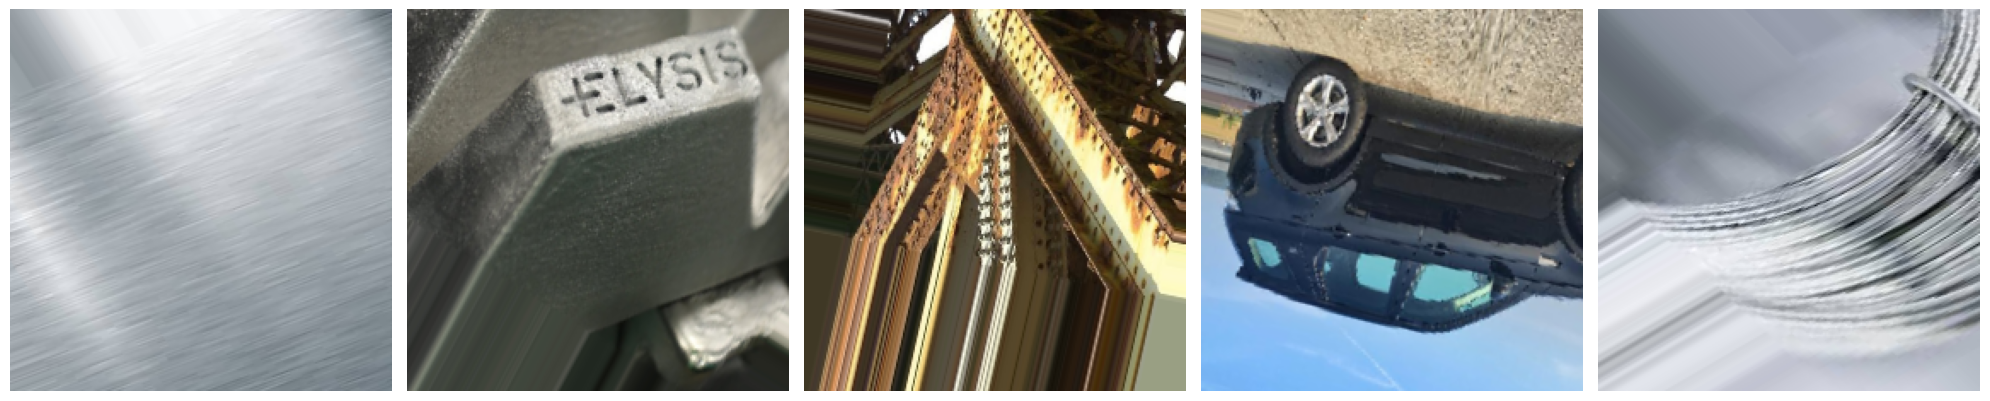

In [ ]:
# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Check if all files are valid images
for filepath in train_generator.filepaths:
    try:
        img = Image.open(filepath)
        # You can add additional checks here, such as verifying image format
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")

# Get a batch of images from the training generator
sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same')(x1)
    x = concatenate([x, x1], axis=-1)
    return x

def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        x = conv_block(x, growth_rate)
    return x

def transition_block(x, compression):
    num_filters = int(x.shape[-1] * compression)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (1, 1))(x)
    x = MaxPooling2D((2, 2))(x)
    return x

def DenseNet121(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Dense blocks
    x = dense_block(x, num_layers=6, growth_rate=32)
    x = transition_block(x, compression=0.5)
    x = dense_block(x, num_layers=12, growth_rate=32)
    x = transition_block(x, compression=0.5)
    x = dense_block(x, num_layers=24, growth_rate=32)
    x = transition_block(x, compression=0.5)
    x = dense_block(x, num_layers=16, growth_rate=32)
    x = Dropout(0.2)(x)

    # Final layers
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(x)

    model = Model(inputs, x)
    return model

# --- Data preprocessing ---
img_width, img_height = 224, 224  # Adjust image size as needed
num_classes = 2  # Replace with the number of classes in your dataset

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling for validation and test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir_train,
    target_size=(img_width, img_height),
    batch_size=32,  # Adjust batch size as needed
    class_mode='binary'  # Use 'binary' for two classes
)

validation_generator = val_datagen.flow_from_directory(
    dataset_dir_val,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir_test,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

# --- Model creation and training ---
input_shape = (img_width, img_height, 3)  # Assuming RGB images
model = DenseNet121(input_shape, num_classes)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),  # You can experiment with different optimizers
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# --- Evaluation ---
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# --- Evaluation ---
score2 = model.evaluate(train_generator)
print('Train loss:', score2[0])
print('Train accuracy:', score2[1])

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1184s 29s/step - accuracy: 0.6440 - loss: 0.8010 - val_accuracy: 0.4602 - val_loss: 427.0132
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.6875 - loss: 0.6204 - val_accuracy: 0.3333 - val_loss: 479.9504
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1010s 26s/step - accuracy: 0.6986 - loss: 0.5877 - val_accuracy: 0.4716 - val_loss: 12.3645
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7500 - loss: 0.5370 - val_accuracy: 0.7500 - val_loss: 3.7333
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1020s 26s/step - accuracy: 0.7184 - loss: 0.5567 - val_accuracy: 0.5483 - val_loss: 1.7679
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6562 - loss: 0.5852 - val_accuracy: 0.5833 - val_loss: 1.0529
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1021s 26s/step - accuracy: 0.7204 - loss: 0.5717 - val_accurac

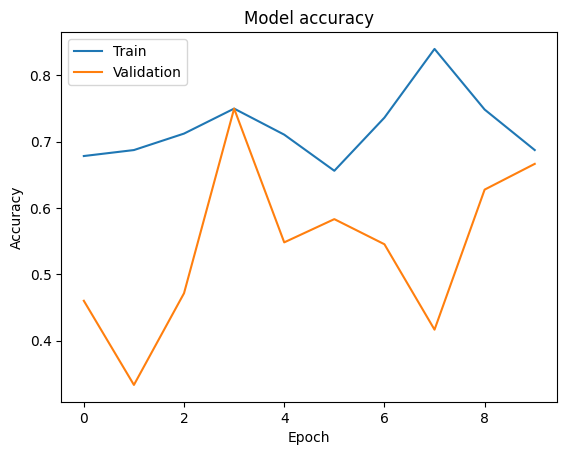

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

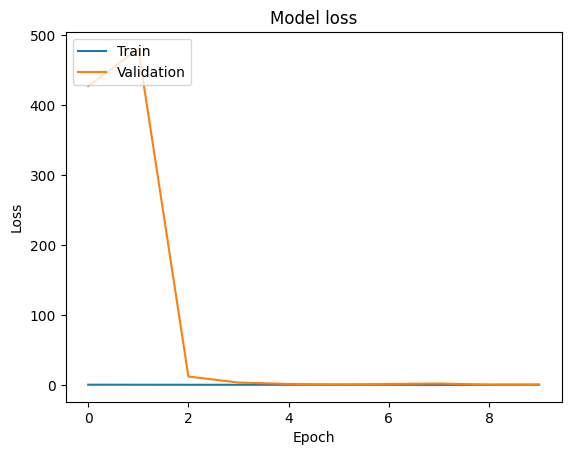

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step

Accuracy: 0.5274725274725275
Precision: 0.42105263157894735
Recall: 0.0963855421686747
F1-score: 0.1568627450980392
ROC AUC: 0.4926372155287818


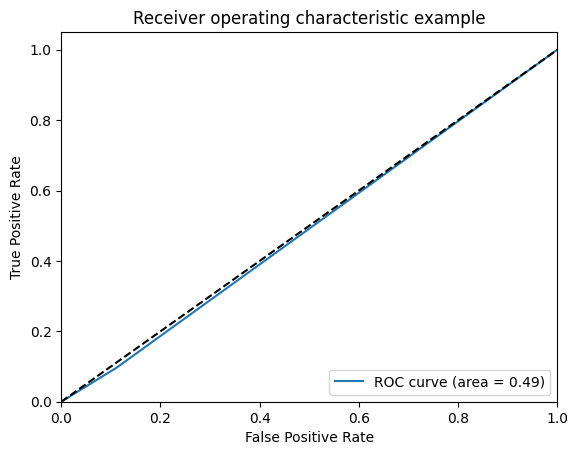

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Get predictions
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Print metrics
print('\nAccuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('ROC AUC:', roc_auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image for prediction
img_path = '/content/drive/MyDrive/test/NOCORROSION/0aee9cae21.jpg'  # Replace with the actual path
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale the image

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("Corrosion detected")
else:
    print("No corrosion detected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
No corrosion detected


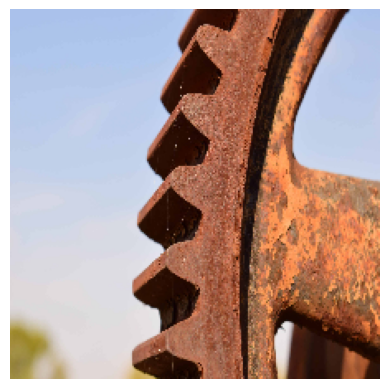

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No corrosion detected


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = '/content/drive/MyDrive/test/CORROSION/000014.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("Corrosion detected")
else:
    print("No corrosion detected")

In [ ]:
#plot the training curves
import pandas as pd
pd.DataFrame(history1.history).plot(figsize =(5,4));

NameError: name 'history1' is not defined